# Univariate Statistical analyses - Summer School 2023
**Auhtor**: Filip Ottosson
faot@ssi.dk

2023-06-30

**Data**

Non-invasive drug monitoring is desirable as it improves patient experience. Instead of relying on invasive blood draws drug pharmacokinetics and metabolism could for example be monitored through the skin. In this tutorial we will be working with a subset of the data published by Panitchpakdi and collaborators (2022). The datasets consists of plasma and skin swabs (forearm, forehead and upper back) collected from healthy volunteers (n=7) over the course of 24 hours, who have been administered the antihistaminic diphenhydramine.

**Questions**

We will explore whether there are differences in blood and skin metabolites time points. The analyses will be performed using Kruskal–Wallis test by ranks, given the lack of normality in metabolomics datasets.

##Install libraries

**Install packages needed to perform the analyses**

In [1]:
install.packages("tidyverse")
install.packages("ggsci")
install.packages("cowplot")
install.packages("ggrepel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘textshaping’, ‘conflicted’, ‘jsonlite’, ‘ragg’


Warning message in install.packages("tidyverse"):
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in install.packages("tidyverse"):
“installation of package ‘ragg’ had non-zero exit status”
Warning message in install.packages("tidyverse"):
“installation of package ‘tidyverse’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’




In [2]:
suppressPackageStartupMessages({
library(tidyverse)
library(ggsci)
library(cowplot)
library(ggrepel)
})

# Read and arrange dataset

**Read dataset from github**

In [67]:
## feature table
ft_url <- 'https://raw.githubusercontent.com/ssi-dk/CD-MRG-metabolomics_summerschool_2023/main/data/mzmine_output/Example/test_ft_group3_MS2_quant.csv'
## metadata
md_url <- 'https://raw.githubusercontent.com/ssi-dk/CD-MRG-metabolomics_summerschool_2023/main/data/metadata/metadata.txt'

In [75]:
ft <- read.csv(ft_url)
md <- read.csv(md_url,sep="\t")

**Data clean up is performed below**

Data columns that are not needed for the present analyses are removed

In [79]:
dat <- ft[,14:ncol(ft)]

Transpose feature table and merge with metadata. Sample names are cleaned so they match between metadata and feautes table

In [80]:
dat <- data.frame(t(dat))
colnames(dat) <- ft$row.ID

In [81]:
dat$filename <- rownames(dat)
dat$filename <- gsub(".mzXML.Peak.area","",gsub(".mzML.Peak.area","",dat$filename))
md$filename <- gsub(".mzXML","",gsub(".mzML","",md$filename))

In [83]:
Data <- merge(md,dat,by="filename")

We make sure that all samples from the feature table could match the metadata table.

In [118]:
dim(Data)
dim(md)
dim(dat)

[1]   88 6588

[1] 172   5

[1]   89 6583

Visualize the dataset. Metadata variables populate the first 5 columns and the remainig columns are metabolite features.

In [119]:
Data[1:5,1:10]

,filename,Individual,ATTRIBUTE_Sample_Type,ATTRIBUTE_Subject,ATTRIBUTE_Timepoint_min,ATTRIBUTE_Sampling_Location,6,7,12,13
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,bldplt1_01_0_1,01,plasma,Subject_1,0,not applicable,83734.85,0,134500.30,0
2,bldplt1_01_120_1,01,plasma,Subject_1,120,not applicable,90452.62,0,107691.70,0
3,bldplt1_01_600_1,01,plasma,Subject_1,600,not applicable,131916.34,0,137687.84,0
4,bldplt1_01_720_1,01,plasma,Subject_1,720,not applicable,48136.74,0,56454.49,0
5,bldplt1_03_0_1,03,plasma,Subject_3,0,not applicable,91555.57,0,88344.92,0


We create a column called "Individual" and move it just after the filename column

In [88]:
Data$filename <- gsub("bld_","bld",Data$filename)
Data <- Data %>% add_column(Individual=sapply(1:nrow(Data),function(n){str_split(Data$filename,"_")[[n]][2]}),
                            .before=2)

We double check that each individual have 2 samples (one plasma and one skin) at each timepoint.

In [90]:
table(Data$ATTRIBUTE_Timepoint_min,Data$Individual)

                
                 01 03 04 05 07 08 10 blank blk
  0               2  2  2  2  2  2  2     0   0
  120             2  2  2  2  2  2  2     0   0
  240             2  2  2  2  2  2  2     0   0
  480             2  2  2  2  2  2  2     0   0
  600             2  2  2  2  2  2  2     0   0
  720             2  2  2  2  2  2  2     0   0
  not applicable  0  0  0  0  0  0  0     2   2

# Run Kruskall-Wallis analyses
Test if there are associations between the plasma metabolome and time after administration of drug

In [92]:
Data_plasma <- subset(Data,ATTRIBUTE_Sample_Type=="plasma")

In [93]:
output_plasma <- data.frame(colnames(Data_plasma[7:ncol(Data_plasma)]))
colnames(output_plasma) <- "Metabolite"
output_plasma$p <- sapply(7:ncol(Data_plasma),function(n){kruskal.test(Data_plasma[,n]~Data_plasma$ATTRIBUTE_Timepoint_min)$p.value})
output_plasma$p_fdr <- p.adjust(output_plasma$p,method = "fdr")

In [94]:
output_plasma <- merge(output_plasma,ft[,1:3],by.x="Metabolite",by.y="row.ID") %>% arrange (p)
output_plasma$significant <- ifelse(output_plasma$p_fdr<0.05,"Significant","Nonsignificant")

Show the strongest associations

In [95]:
output_plasma %>% head(n=15)

,Metabolite,p,p_fdr,row.m.z,row.retention.time,significant
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,5310,1.317163e-06,0.005503067,272.1647,3.547069,Significant
2,4203,2.791863e-06,0.005503067,418.2232,3.176950,Significant
3,7451,2.827886e-06,0.005503067,167.0858,4.290824,Significant
4,4897,1.715483e-05,0.019623330,167.0858,3.402496,Significant
5,4906,1.842295e-05,0.019623330,256.1697,3.407958,Significant
6,7445,2.305341e-05,0.019623330,265.0832,4.289404,Significant
7,4220,2.352917e-05,0.019623330,432.2014,3.182148,Significant
8,10486,3.075698e-05,0.022444905,315.2531,5.727820,Significant
9,1910,6.374296e-05,0.041347931,448.1976,2.457238,Significant


Plot p-values for all features vs the m/z

In [96]:
kruskal_plot <- ggplot(output_plasma,aes(y=-log(p,base=10),x=row.m.z,color=significant))+
geom_point(alpha=0.7)+
theme_classic()+
xlab("m/z")+
ylab("-log(p)")+
scale_x_continuous(limits = c(50,1000))+
scale_color_npg()+
geom_text_repel(data=subset(output_plasma,p_fdr<0.05),aes(label=round(row.m.z,2)))+
theme(legend.position = "none")

Warning message:
“Removed 776 rows containing missing values (`geom_point()`).”


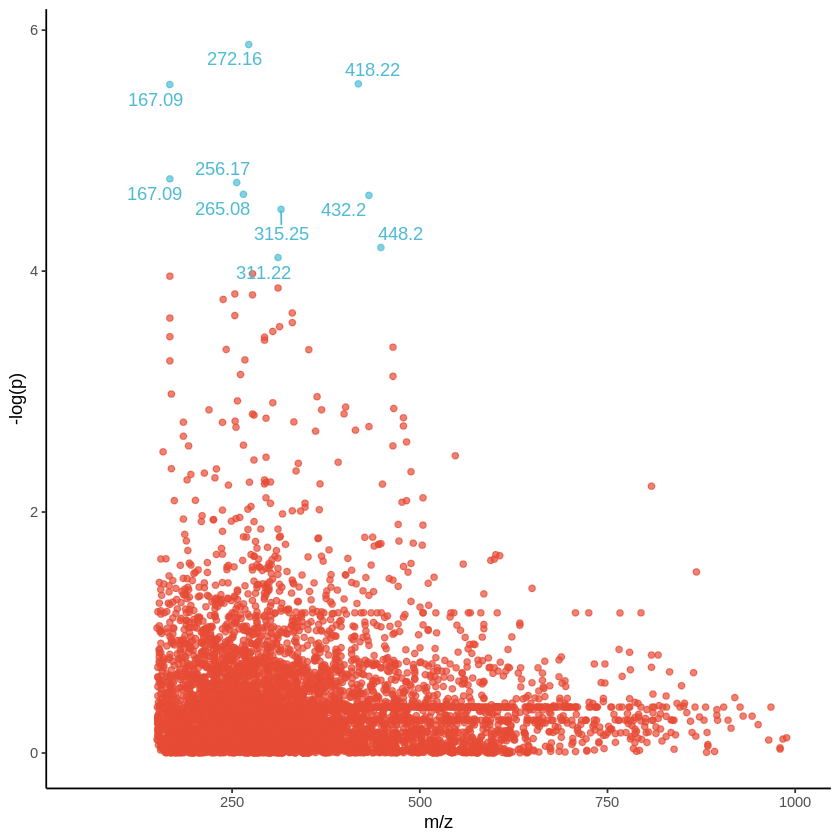

In [97]:
kruskal_plot

Find significant features

In [98]:
significant_features <- as.numeric(as.character(subset(output_plasma,p_fdr<0.05)[,1]))

Create subset dataset with only metabolites with significant p-values from the Kruskal-Wallis test

In [99]:
Data_significant <- Data[colnames(Data) %in% c(names(Data)[1:6],significant_features)]

Perform Kruskall Wallis analyses for significant plasma metabolites in skin samples in order to find metabolites that are also changed in skin samples after drug administration

In [101]:
Data_skin <- subset(Data_significant,ATTRIBUTE_Sample_Type=="skin")

In [103]:
output_skin <- data.frame(colnames(Data_skin[7:ncol(Data_skin)]))
colnames(output_skin) <- "Metabolite"
output_skin$p <- sapply(7:ncol(Data_skin),function(n){kruskal.test(Data_skin[,n]~Data_skin$ATTRIBUTE_Timepoint_min)$p.value})
output_skin$p_fdr <- p.adjust(output_skin$p,method = "fdr")

Show results of analyses

In [104]:
merge(output_skin,ft[,1:3],by.x="Metabolite",by.y="row.ID") %>% arrange (p)

Metabolite,p,p_fdr,row.m.z,row.retention.time
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
4897,8.541693e-06,2.710855e-05,167.0858,3.402496
4906,9.036184e-06,2.710855e-05,256.1697,3.407958
5310,7.239075e-02,1.447815e-01,272.1647,3.547069
7451,4.044733e-01,6.067099e-01,167.0858,4.290824
10486,7.010103e-01,8.412123e-01,315.2531,5.727820
6376,8.878757e-01,8.878757e-01,311.2220,3.819185
1910,NaN,NaN,448.1976,2.457238
4203,NaN,NaN,418.2232,3.176950
4220,NaN,NaN,432.2014,3.182148


Select significant features

In [107]:
significant_features_skin <- as.numeric(as.character(subset(output_skin,p_fdr<0.05)[,1]))

In [108]:
Data_significant <- Data[colnames(Data) %in% c(names(Data)[1:6],significant_features_skin)]

In [110]:
Data_significant <- subset(Data_significant,ATTRIBUTE_Sample_Type=="plasma"|ATTRIBUTE_Sample_Type=="skin")
Data_significant$ATTRIBUTE_Timepoint_min <- as.numeric(as.character(Data_significant$ATTRIBUTE_Timepoint_min))

# Plot timetrends

Visualize how levels of the significant metabolites change over time in both plasma and skin samples.

In [114]:
plot_scatter_4906 <- ggplot(Data_significant,aes(x=ATTRIBUTE_Timepoint_min,Data_significant$"4906",color=ATTRIBUTE_Sample_Type,group=ATTRIBUTE_Sample_Type,fill=ATTRIBUTE_Sample_Type))+
    geom_point(size=1, alpha=0.5)+
    theme_minimal()+
    geom_smooth(method="loess")+
    ggtitle("Time trend m/z 256.1697")+
    xlab("Time (minutes)")+
    ylab("Peak Area")+
    theme(legend.position = "none")+
    scale_color_npg()+
    scale_fill_npg()+
    scale_x_continuous(breaks=c(0,120,240,480,600,720))



In [115]:
plot_scatter_4897 <- ggplot(Data_significant,aes(x=ATTRIBUTE_Timepoint_min,Data_significant$"4897",color=ATTRIBUTE_Sample_Type,group=ATTRIBUTE_Sample_Type,fill=ATTRIBUTE_Sample_Type))+
    geom_point(size=1, alpha=0.5)+
    theme_minimal()+
    geom_smooth(method="loess")+
    ggtitle("Time trend m/z 167.0858")+
    xlab("Time (minutes)")+
    ylab("Peak Area")+
    theme(legend.position = "bottom")+
    scale_color_npg()+
    scale_fill_npg()+
    scale_x_continuous(breaks=c(0,120,240,480,600,720))


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


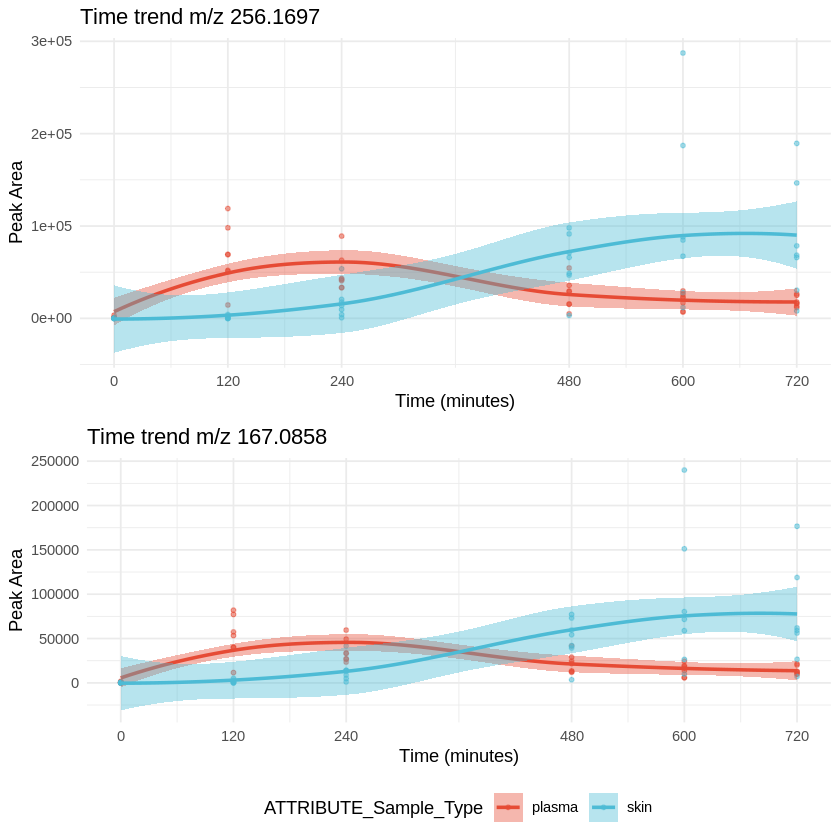

In [116]:
plot_grid(plot_scatter_4906,plot_scatter_4897,
          ncol=1,nrow=2)